# DM2021-Lab1-Homework Part 3

## Table of Contents
0. Preparing Data
2. TF-IDF Features
3. NB Classifier
 - 3.1 NB Classsifier with tfidf features
 - 3.2 Word frequency features
 - 3.3 NB Classifier with word frequency features
 - 3.4 Comparing the classifiers
1. New Visualizations
 - 1.1 Test size vs accuracy of classifiers

## 0. Preparing Data

In [1]:
import helpers.data_mining_helpers as dmh

amazon_data = dmh.retrieve_new_data('amazon_cells_labelled.txt')
imdb_data = dmh.retrieve_new_data('imdb_labelled.txt')
yelp_data = dmh.retrieve_new_data('yelp_labelled.txt')
data_train = amazon_data + imdb_data + yelp_data

In [2]:
# Making pandas Dataframe

import pandas as pd

for text in data_train:
    text[0] = text[0].strip('\t.')
X = pd.DataFrame.from_records(data_train, columns= ['text', 'category'])

In [3]:
# Dropping duplicates

X.drop_duplicates(keep='first', inplace=True)

In [4]:
categories = ['negative', 'positive']

In [5]:
# Checking for missing values

X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category
0,The amount of missing records is:,The amount of missing records is:
1,0,0


In [6]:
# Adding category name label

X['category_name'] = X.category.apply(lambda t: categories[int(t)])

negative    1493
positive    1490
Name: category_name, dtype: int64


<AxesSubplot:title={'center':'Category distribution'}>

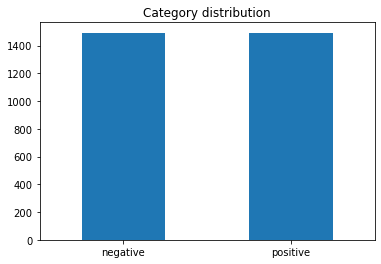

In [7]:
# Checking category distribution

import matplotlib.pyplot as plt
print(X.category_name.value_counts())

X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    rot = 0)

## 2. TF-IDF features

In [8]:
# Creating tfidf features

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vect = TfidfVectorizer()
X_TFIDF = tfidf_vect.fit_transform(X.text)

In [9]:
# Filtering terms in dictionary

import enchant
d = enchant.Dict('en_US')
terms = tfidf_vect.get_feature_names()
terms_enUS = []
select_index = []
for i in range(0, len(terms)):
    if d.check(terms[i]) and terms[i].isalpha():
        terms_enUS.append(terms[i])
        select_index.append(i)
        
X_TFIDF_en_US = X_TFIDF.tocsr()[:, select_index]

In [10]:
X_TFIDF_en_US.shape

(2983, 4421)

## 3. NB Classifier

### 3.1 NB Classsifier with tfidf features

In [11]:
# Creating nb classifier with tfidf features

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_TFIDF_en_US, list(X.category), test_size=0.25)

bnb_TFIDF = BernoulliNB()
bnb_TFIDF.fit(X_train, Y_train)
score_tfidf = bnb_TFIDF.score(X_test, Y_test)

In [12]:
def classify_tfidf(sent):
    return bnb_TFIDF.predict(tfidf_vect.transform(sent)[:, select_index])

In [13]:
# Checking the classifier

sent = ['It was a great movie',
        'Waste of my time',
        'Served rotten food']
classify_tfidf(sent)

array(['1', '0', '0'], dtype='<U1')

### 3.2 Word frequency features

In [14]:
# Creating word frequency features

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text)
X_counts_en_US = X_counts.tocsr()[:, select_index]

In [15]:
X_counts_en_US.shape

(2983, 4421)

### 3.3 NB Classifier with word frequency features

In [16]:
# Creating nb classifier with word frequency features

X_train, X_test, Y_train, Y_test = train_test_split(X_counts_en_US, list(X.category), test_size=0.25)

bnb_counts = BernoulliNB()
bnb_counts.fit(X_train, Y_train)
score_counts = bnb_counts.score(X_test, Y_test)

In [17]:
def classify_counts(sent):
    return bnb_counts.predict(count_vect.transform(sent)[:, select_index])

In [18]:
# Checking the classifier

sent = ['It was a great movie',
        'Waste of my time',
        'Served rotten food']
classify_counts(sent)

array(['1', '0', '0'], dtype='<U1')

### 3.4 Comparing the classifiers

<BarContainer object of 2 artists>

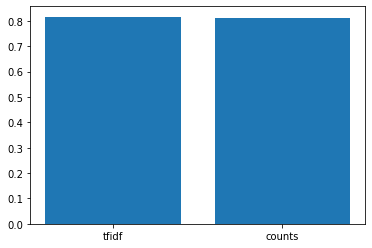

In [19]:
plt.bar(['tfidf', 'counts'], [score_tfidf, score_counts])

## 1. New Visualizations

### 1.1 Test size vs accuracy of classifiers

In [20]:
# Plotting test size vs accuracy

accuracy_tfidf = []
test_size = [float(round(i, 2)) for i in np.arange(0.05, 1, 0.05)]
for i in test_size:
    scores = []
    for j in range(0, 100):
        X_train, X_test, Y_train, Y_test = train_test_split(X_TFIDF_en_US, list(X.category), test_size = i)
        bnb = BernoulliNB(binarize = 0.0)
        bnb.fit(X_train, Y_train)
        scores.append(bnb.score(X_test, Y_test))
    accuracy_tfidf.append(sum(scores)/100)

In [21]:
accuracy_counts = []
test_size = [float(round(i, 2)) for i in np.arange(0.05, 1, 0.05)]
for i in test_size:
    scores = []
    for j in range(0, 100):
        X_train, X_test, Y_train, Y_test = train_test_split(X_counts_en_US, list(X.category), test_size = i)
        bnb = BernoulliNB(binarize = 0.0)
        bnb.fit(X_train, Y_train)
        scores.append(bnb.score(X_test, Y_test))
    accuracy_counts.append(sum(scores)/100)

Text(0, 0.5, 'accuracy')

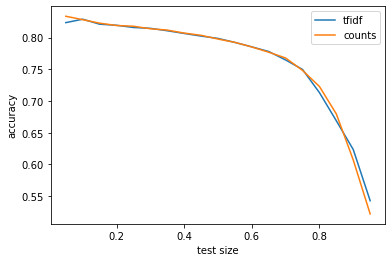

In [22]:
plt.plot(test_size, accuracy_tfidf, label = 'tfidf')
plt.plot(test_size, accuracy_counts, label = 'counts')
plt.legend()
plt.xlabel('test size')
plt.ylabel('accuracy')

In [23]:
# Very similar performance